# Time domain forward modelling and inversion notebook V0.1

In [10]:
# import SimPEG.dask as simpeg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import time_domain as tdem, utils as EMutils
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from scipy.interpolate import interp1d


## Loading the simulation

Load the *.msh file and *.mod file which are UBC formatted. We can extract the active cells by searching for the value used to indicate air cells on line 10 of the following cell

A histogram of the model is generated to get an idea of how many units are present

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\mixins\mesh_io.py:594: FutureWarning: TensorMesh.readUBC has been deprecated and will be removed indiscretize 1.0.0. please use TensorMesh.read_UBC
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


(77988,) 77988 60820


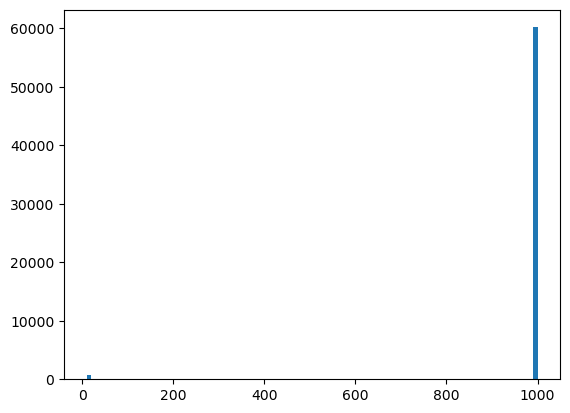

0.001 0.1


In [11]:
# let import the mesh in UBC format
mesh_file = r".\octree_mesh\octree_mesh.txt"
mesh = discretize.TreeMesh.readUBC(mesh_file)

# load the conductivity model
conductivity_file = r".\octree_model\octree_model.con"
model = discretize.TreeMesh.readModelUBC(mesh, conductivity_file)

# extract the acive files
actinds = model > 1e-8

print(model.shape, mesh.nC, actinds.sum())

plt.hist(1 / model[actinds], 100)
plt.show()

print(model[actinds].min(), model[actinds].max())


## Load the receiver stations array

Simply load in a CSV file with utm easting, northing and elevation.

receiver numbers: (100, 3)


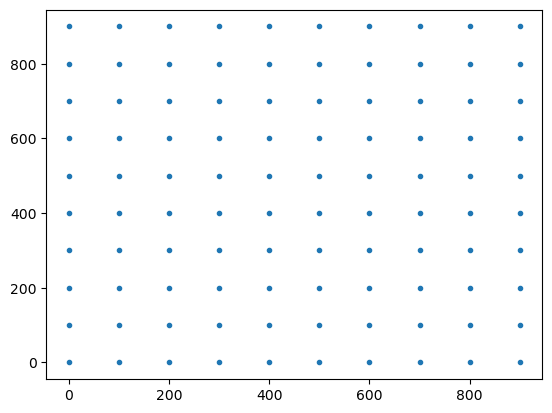

In [12]:
# create receivers
rx_x, rx_y = np.meshgrid(np.arange(0, 1000, 100), np.arange(0, 1000, 100))
receivers = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.ones((np.prod(rx_x.shape), 1))*50.0))
print(f"receiver numbers: {receivers.shape}")

plt.plot(receivers[:, 0], receivers[:, 1], '.')
plt.show()


## Load UBC results

In [13]:
def rotate_array(arr, angle):
    """
    Rotate a 2D numpy array about its center point.
    
    Parameters:
        arr (numpy.ndarray): 2D numpy array to be rotated.
        angle (float): angle in degrees by which to rotate the array (positive angle rotates counterclockwise).
    
    Returns:
        numpy.ndarray: rotated 2D numpy array.
    """
    # get the shape of the array
    rows, cols = arr.shape
    
    # calculate the center point of the array
    center_row = rows // 2
    center_col = cols // 2
    
    # create a rotation matrix
    radians = np.deg2rad(angle)
    cos_theta = np.cos(radians)
    sin_theta = np.sin(radians)
    rotation_matrix = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    
    # calculate the indices of the pixels in the rotated array
    indices = np.indices((rows, cols)).reshape(2, -1)
    indices -= np.array([[center_row], [center_col]])
    rotated_indices = np.matmul(rotation_matrix, indices).round().astype(int)
    rotated_indices += np.array([[center_row], [center_col]])
    
    # ensure that the rotated indices are within the bounds of the array
    valid_indices = np.logical_and(rotated_indices[0] >= 0, rotated_indices[0] < rows)
    valid_indices = np.logical_and(valid_indices, rotated_indices[1] >= 0)
    valid_indices = np.logical_and(valid_indices, rotated_indices[1] < cols)
    rotated_indices = rotated_indices[:, valid_indices]
    
    # create the rotated array
    rotated_arr = np.zeros_like(arr)
    rotated_arr[rotated_indices[0], rotated_indices[1]] = arr[indices[0, valid_indices], indices[1, valid_indices]]
    
    return rotated_arr


ubc_read = open(r".\data_input\dobs.txt")

gates = [
    1.000000e-04,
    1.584893e-04,
    2.511886e-04,
    3.981072e-04,
    6.309573e-04,
    1.000000e-03,
    1.584893e-03,
    2.511886e-03,
    3.981072e-03,
    6.309573e-03,
    1.000000e-02,
]
# organise data by frequency index
ubc_dat = {}

for ii in range(len(gates)):

    ubc_dat[ii] = {

        'dbzdt': [],
    }

fcnt = 0
findx = 0

for line in ubc_read.readlines():

    line = line.split()

    if len(line) > 1 and '%' not in line:

        if fcnt == 100:

            fcnt = 0
            findx += 1

            ubc_dat[findx]["dbzdt"] += [float(line[4])]

        else:

            ubc_dat[findx]["dbzdt"] += [float(line[4])]

        fcnt += 1

# print(len(ubc_dat[findx - 1]['tzxr']))

# now create a vectore similar to dobs in simpeg
ubc_obs = []

for ii in range(11):

    ubc_obs.append(ubc_dat[ii]['dbzdt'])

print(np.array(ubc_obs).shape)
ubc_obs = np.array(ubc_obs).flatten()


(11, 100)


## Setting up the simulation

Here the background is set to the median of the model provided. This may or may not need to be adjusted depedning on the experiment.

The model slice is also generated to confirm simulated targets.

In [32]:
# set signal times
offtime_steps = [
    1.000000e-04,
    1.584893e-04,
    2.511886e-04,
    3.981072e-04,
    6.309573e-04,
    1.000000e-03,
    1.584893e-03,
    2.511886e-03,
    3.981072e-03,
    6.309573e-03,
    1.000000e-02,
]

# time_steps = [
# (1.000e-5, 20),
# (3.000e-5, 20),
# (1.000e-4, 20),
# (3.000e-4, 20),
# (1.000e-3, 20),
# (3.000e-3, 20), 
# (1.5e-2, 20),
# ]

# --------------------------------------------------------------------------------------------------------

# load up the times from ubc

#

t_steps_ubc_file = np.genfromtxt(r".\data_input\wave.txt")[:, 0]

print(t_steps_ubc_file.shape)

time_steps = np.diff(t_steps_ubc_file)
print(time_steps.shape)

# --------------------------------------------------------------------------------------------------------

# setup the simulation

#

background = 1000.0 # np.median(model[actinds])
# create background conductivity model
sigBG = np.zeros(mesh.nC) + 1 / background
sigBG[~actinds] = 1e-8

# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=actinds, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * actMap

# Setup the simulation object
sim = tdem.Simulation3DElectricField(
    mesh,
    sigmaMap=mapping,
    solver=Solver
)
sim.time_steps = time_steps

# Make a receiver list
# Use VTEM waveform
# out = EMutils.VTEMFun(np.array(sim.times), 0.00595, 0.0, 100)

# # Forming function handle for waveform using 1D linear interpolation
# wavefun = interp1d(sim.times, out)
t0 = 0.0
# waveform = tdem.Src.RawWaveform(off_time=t0, waveform_function=wavefun)

rx = [tdem.Rx.PointMagneticFluxTimeDerivative(
    receivers[ii, :], np.array(offtime_steps) + t0, "z"
) for ii in range(receivers.shape[0])] 


src_list = [tdem.Src.CircularLoop(
    [rx[ii]], location=receivers[ii, :], radius=5.0
) for ii in range(len(rx))]

survey = tdem.Survey(src_list)


(117,)
(116,)


## Running the forward simulation

Here simpeg map and simulation objects are created which are then used to calculate the forward data using the geological model imported in UBC format.

In [33]:

# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=actinds, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * actMap

# Setup the simulation object
sim = tdem.Simulation3DElectricField(
    mesh,
    survey=survey,
    sigmaMap=mapping,
    time_steps=time_steps,
    solver=Solver
)

# -------------------------------------------------------------

# calculate the fields

#

import time
active = actinds
source_list = src_list
models = {

    "L_block": np.log(model[active]),
}

fields = {}

for key, sig in models.items():
    if key not in fields.keys(): 
        print(f"starting {key}")
        t = time.time()
        fields[key] = sim.fields(sig)
        print(f"done {key}... elapsed time: {time.time()-t:1.1e}s \n")

sim.survey = survey
sim.survey.dtrue = sim.dpred(np.log(model[actinds]), f=fields["L_block"])
# # create observations
# sim.survey.dobs = sim.survey.dtrue


starting L_block


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TreeMesh.edgeCurl has been deprecated, please use TreeMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\pymatsolver\direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.getFaceInnerProduct has been deprecated, please use TreeMesh.get_face_inner_product. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\pymatsolver\direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


done L_block... elapsed time: 3.5e+03s 



c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.getInterpolationMat has been deprecated, please use TreeMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TensorMesh.getInterpolationMat has been deprecated, please use TensorMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


## Plotting the simulation data

Line 11 and 20 will need to be adjusted accoringly depending on the data being observed.

[-3.16539525e-10 -1.34918482e-10 -4.99921631e-11 ... -4.80799177e-14
 -1.43222362e-14 -4.42435915e-15] (100, 3)
100
100


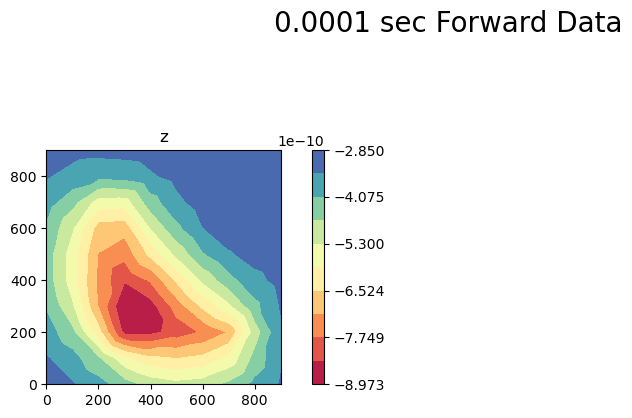

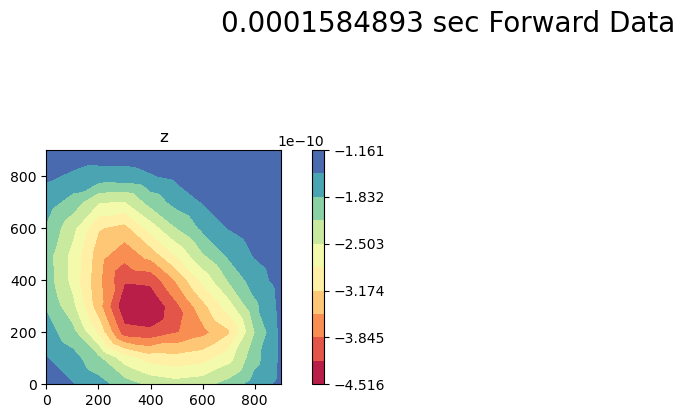

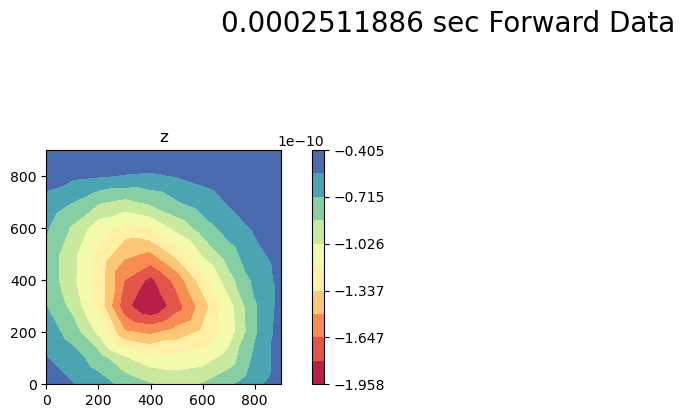

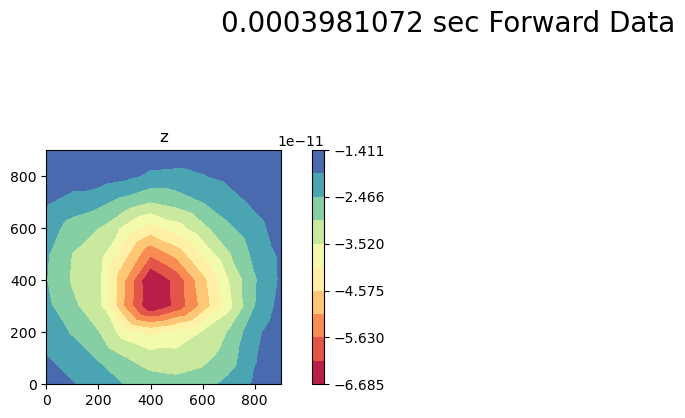

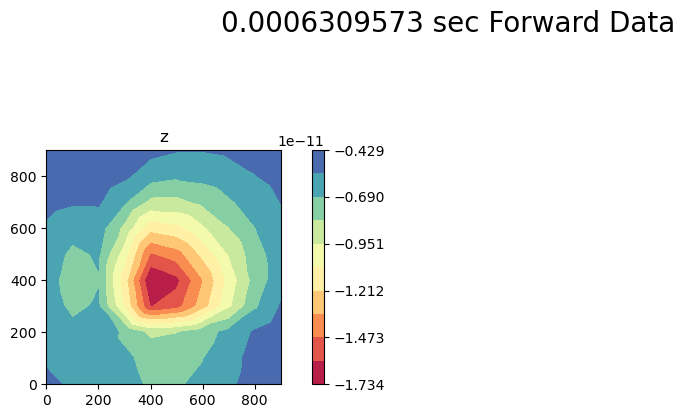

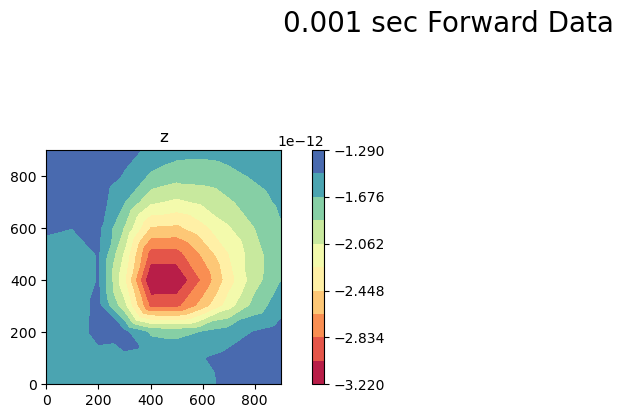

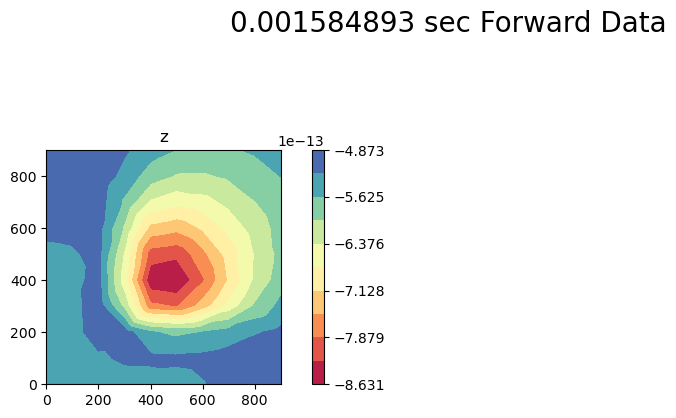

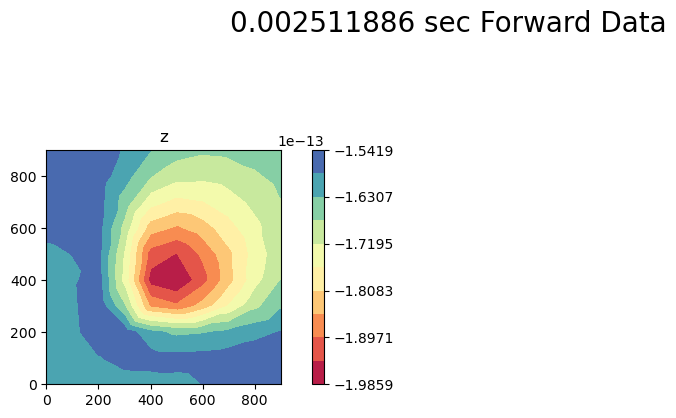

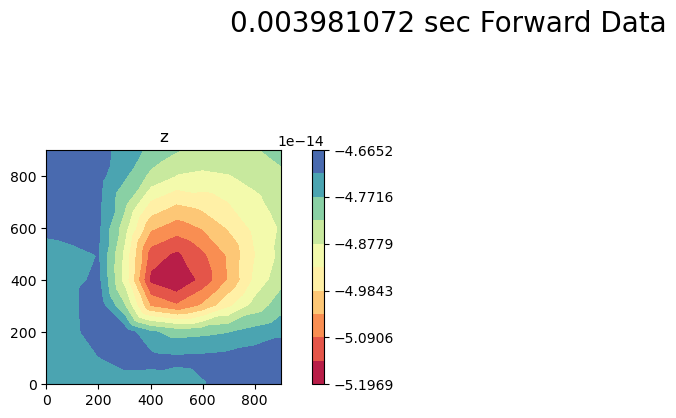

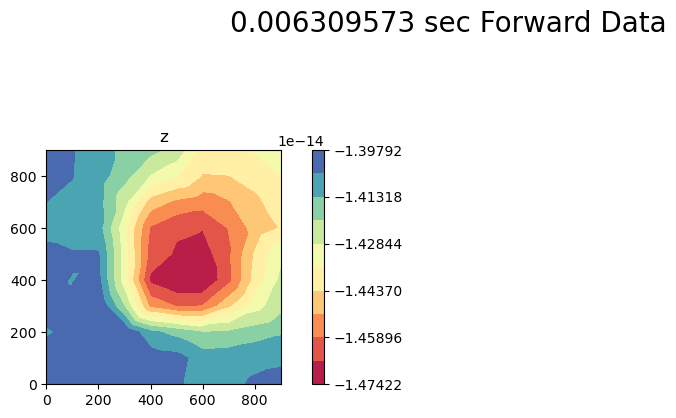

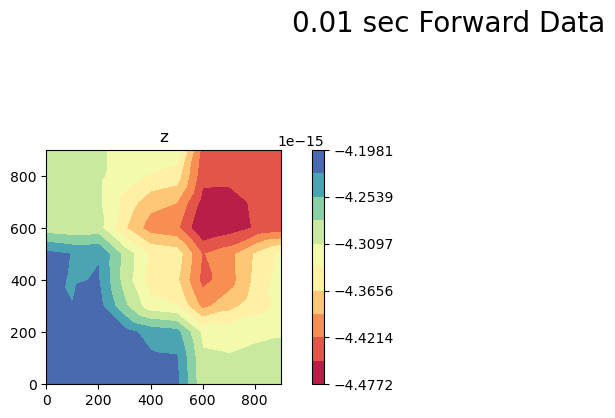

[1.58269763e-11 6.74592411e-12 2.49960815e-12] (1100,)


In [34]:
sim.survey.dobs = sim.survey.dtrue
print(survey.dobs, receivers.shape)
# Assign uncertainties
std = 0.05  # 5% std
sim.survey.std = np.abs(survey.dobs) * std
# make data object
fwd_data = data.Data(sim.survey)

gates = [
    1.000000e-04,
    1.584893e-04,
    2.511886e-04,
    3.981072e-04,
    6.309573e-04,
    1.000000e-03,
    1.584893e-03,
    2.511886e-03,
    3.981072e-03,
    6.309573e-03,
    1.000000e-02,
]

# reshape data for plotting
print(receivers.shape[0])
num_station = receivers.shape[0]

num_frequencies = len(gates)

num_sets = int(survey.dobs.shape[0] / num_frequencies) # len(gates))
print(num_sets)
dnew = np.reshape(survey.dobs, (num_frequencies, num_sets), order='F')
ubc_dnew = np.reshape(ubc_obs, (num_frequencies, num_sets), order='F')
stdnew = np.reshape(survey.std, (num_frequencies, num_sets), order='F')

cnt = 0

profile_hold = []

for freq in range(len(gates)):
    cnt_comp = 0
    # comps_ = ['rho_xy', 'phi_xy', 'rho_yx', 'phi_yx']
    comps_ = ['z']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        pert = 1e-3
        pert_diag = 0  #np.percentile(np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]), 10)
            
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(receivers, dnew[freq, :], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(str(gates[freq]) + ' sec Forward Data', fontsize='20')
plt.show()
print(mkvc(stdnew)[:3], stdnew.flatten('F').shape)

### Save the fields

In [10]:
# save the data
directory = '.'

# create half space result
# fields['halfspace'] = sim.fields(np.log(sigBG[active]))

for key in fields.keys():

    for ii in range(len(gates)):

        gate = gates[ii]

        np.save(f"{directory}/fields_{key}_{gate}", fields[key][source_list[ii], :]['eSolution'])

print("saved ")

saved 


### Profile plots

(11, 10)


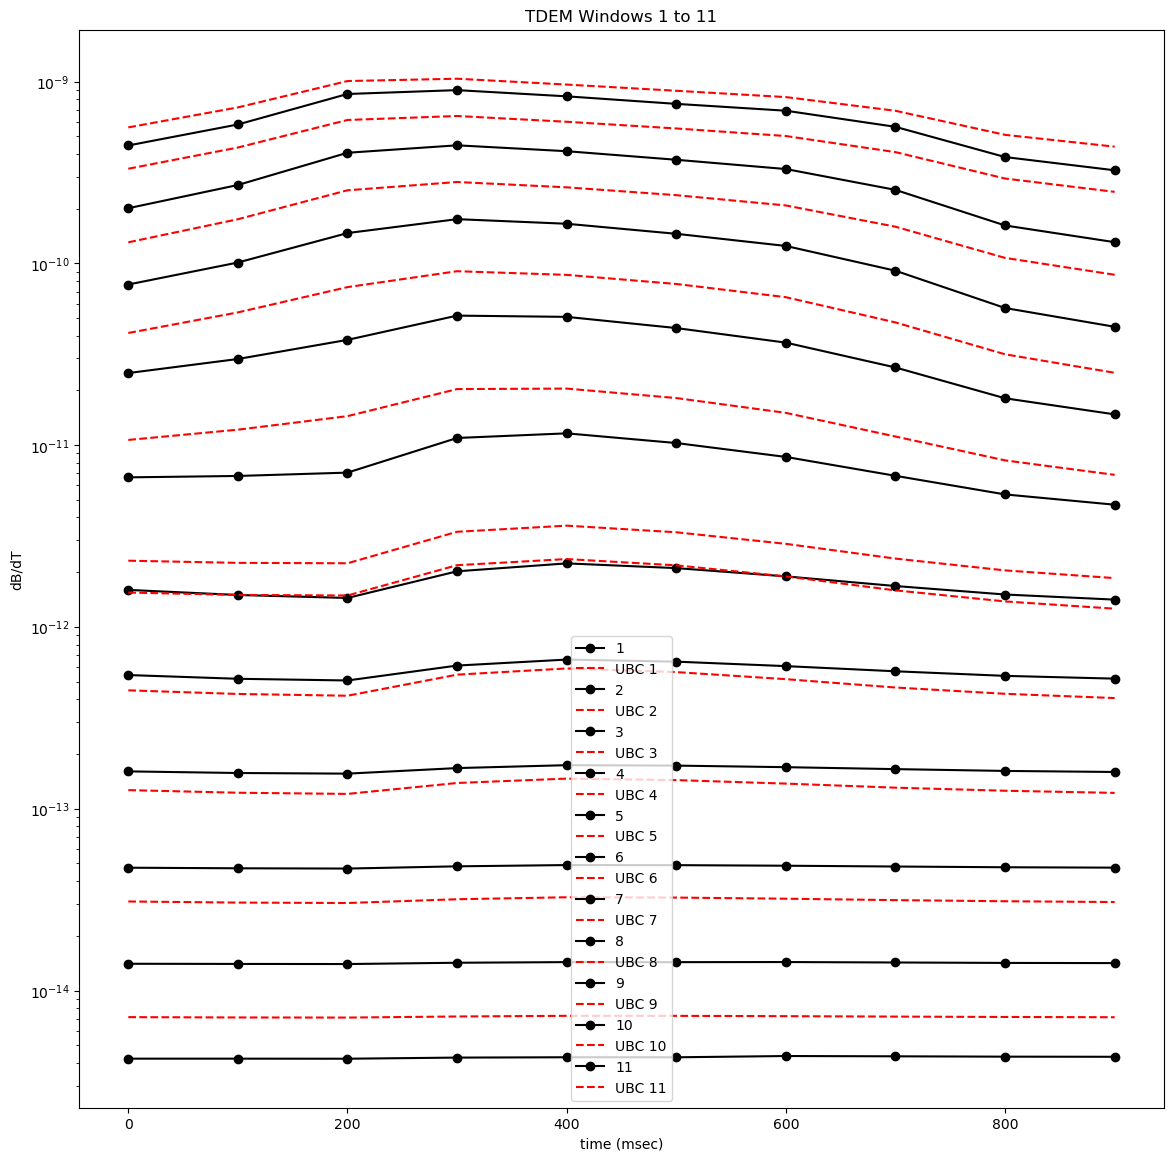

In [36]:
profile_hold = dnew[:, 30:40]
# num_sets = int(ubc_obs.shape[0] / 11) # len(gates))
# ubc_dnew = np.reshape(ubc_obs, (11, num_sets), order='F')
# sim.survey.dobs = sim.survey.dtrue
ubc_profile_hold = ubc_dnew[:, 30:40]

print(profile_hold.shape)
plt.figure(figsize=(14, 14))
for ii in range(profile_hold.shape[0]):
    plt.semilogy(np.arange(0, 1000, 100), -profile_hold[ii, :], '-ok', label=f'{ii + 1}')
    plt.semilogy(np.arange(0, 1000, 100), -ubc_profile_hold[ii, :], '--r', label=f'UBC {ii + 1}')
# plt.plot
plt.title('TDEM Windows 1 to 11')
plt.legend()
plt.xlabel('time (msec)')
plt.ylabel('dB/dT')
plt.show()

# print(sim.survey.dobs.shape, ubc_profile_hold.shape)

# # plt.loglog(gates, -sim.survey.dobs, 'r')
# plt.loglog(gates, -ubc_profile_hold, 'k')
# plt.show()


In [ ]:
from matplotlib.colors import LogNorm, Normalize
from tree_plot import streamplot_tree
# ---------------------------------------------------------------------------------------------------------------------------

# plot the profile subplots

#

data_dict = fwd_data

# lets plot some plots
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

profile_hold = dnew[0:11, 30:40]
ubc_profile_hold = ubc_dnew[0:11, 30:40]

print(profile_hold.shape)
plt.figure(figsize=(14, 14))
for ii in range(profile_hold.shape[0]):
    plt.semilogy(np.arange(0, 1000, 100), -profile_hold[ii, :], '-ok', label=f'{ii + 1}')
    plt.semilogy(np.arange(0, 1000, 100), -ubc_profile_hold[ii, :], '--r', label=f'UBC {ii + 1}')

plt.show()

ax[1, 1].legend()
ax[1, 1].text(-0.1, 1.15, 'd)', transform=ax[1, 1].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
ax[1, 1].set_title('Line 800E')

# ---------------------------------------------------------------------------------------------------------------------------

# plot the plan-map subplots

#

key = "10"
im = utils.plot_utils.plot2Ddata(receivers, profile_data[key]['real'][0], ax=ax[1, 0], contourOpts={'cmap':'Spectral'})
ax[1, 0].set_title(f"{key} ms {comps_[0]}")
plt.colorbar(im[0])

ax[1, 0].text(-0.1, 1.15, 'c)', transform=ax[1, 0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

im = utils.plot_utils.plot2Ddata(receivers, profile_data[key]['imag'][0], ax=ax[2, 0], contourOpts={'cmap':'Spectral'})
ax[2, 0].set_title(f"{key} Hz {comps_[1]}")
plt.colorbar(im[0])

ax[2, 0].text(-0.1, 1.15, 'e)', transform=ax[2, 0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

# ---------------------------------------------------------------------------------------------------------------------------

# plot the slice of currents and B-field subplots

#

ax[0, 0].text(-0.1, 1.15, 'a)', transform=ax[0, 0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

ax[0, 1].text(-0.1, 1.15, 'b)', transform=ax[0, 1].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

frequencies = gates

xlim = np.r_[0, 900]
ylim = np.r_[-700, 100]

key = "L_block"
src_ind = 50
time_ind = 30

print(len(source_list), fields[key][source_list[src_ind], "j"][:, time_ind].min(), fields[key][source_list[src_ind], "j"][:, 21].max(), sim.time_steps)

out = streamplot_tree(
    mesh,
    fields[key][source_list[src_ind], "j"][:, 21], normal="Z", ax=ax[0, 0],
    pcolor_opts={"cmap": 'magma'},
    streamplot_opts={'density':5}
)

plt.colorbar(out[0], ax=ax, shrink=0.5)
ax.set_xlim(xlim)
ax.set_ylim(xlim)
ax.set_title(f"J imag, {np.sum(sim.time_steps[:21])} sec, XZ-slice")
ax.set_aspect(1)


key = "L_block"
ylim = np.r_[-525, 125]
subtract = "halfspace" 

plotme = fields[key][source_list[src_ind], "b"][:, 2]

if subtract is not None:
    plotme = plotme - fields[subtract][source_list[src_ind], "dbdt"][:, time_ind]

out = streamplot_tree(
    mesh,
    plotme, normal="X", ax=ax[0, 1],
    range_x=xlim, range_y=ylim,
    pcolor_opts={"cmap": 'magma'},
    streamplot_opts={'density':5}
)
plt.colorbar(out[1], ax=ax, shrink=0.5, pad=0.1)
ax[0, 1].set_xlim(xlim)
ax[0, 1].set_ylim(ylim)
ax[0, 1].set_title(f"Anomalous dB/dt real, {frequencies[10]} sec, YZ slice")
ax[0, 1].set_aspect(1)

plt.show()

## For inversion

In [ ]:
# Fill the data object
fwd_data.dobs = sim.survey.dobs
fwd_data.standard_deviation = stdnew.flatten()  # sim.survey.std
sim.survey.std = stdnew.flatten()
survey.std = stdnew.flatten()

Wd = 1 / survey.std
plt.hist(Wd, 100)
plt.show()
# Setup the inversion proceedure
# Define a counter
C = utils.Counter()
# Optimization
opt = optimization.ProjectedGNCG(maxIter=1, upper=np.inf, lower=-np.inf)
opt.counter = C
opt.maxIterCG = 20
# opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = data_misfit.L2DataMisfit(data=fwd_data, simulation=sim)
dmis.W = Wd
# Regularization
regmap = maps.IdentityMap(nP=int(active.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)
reg = regularization.Simple(mesh, indActive=active, mapping=regmap)

reg.alpha_s = 4e-6
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 1.
# reg.mrefInSmooth = True
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta schedule
beta = directives.BetaSchedule()
beta.coolingRate = 1.
beta.coolingFactor = 4.
# Initial estimate of beta
beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
targmis = directives.TargetMisfit()
# targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
# Create an inversion object
directive_list = [beta, beta_est, targmis, saveIter]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

# Set the conductivity values
sig_half = 0.01
sig_air = 1e-8
# Make the background model
sigma_0 = np.ones(mesh.nC) * sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

import time
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))

In [ ]:
print(invProb.beta, invProb.phi_d, invProb.phi_m, sim.survey.nD)
# map the conductivity
cond_est = mapping * mopt

# discretize.TensorMesh.writeUBC(mesh,'Lb-imp_all_simple-octree-v2.msh', models={'Lb-imp_all_simple-octree-v2.con': cond_est})

In [ ]:
# modeli = np.ones(mesh.nC) 
modeli = 1 / cond_est
modeli[~active] = np.nan
# modeli[active] = cond_est
plt.figure(figsize=(24, 24))
plt.suptitle('Model')
ax = plt.subplot(2, 2, 1)
collect_obj = mesh.plot_slice(modeli, ax=ax, ind=int(65), grid=True, normal='Y', clim=[1, 100])
color_bar = plt.colorbar(collect_obj[0])
ax.axis('equal')
ax1 = plt.subplot(2, 2, 2)
collect_obj1 = mesh.plot_slice(modeli, ax=ax1, ind=int(70), grid=True, normal='X', clim=[1, 100])
# color_bar1 = plt.colorbar()
ax1.axis('equal')
# plt.show()

ax2 = plt.subplot(2, 2, 3)
collect_obj2 = mesh.plot_slice(modeli, ax=ax2, ind=int(120), grid=True, normal='Z', clim=[1, 100])
# color_bar2 = plt.colorbar()
ax2.set_xlim([-1000, 7000])
ax2.set_ylim([-1000, 7000])
# ax2.axis('equal')
# plt.show()

ax3 = plt.subplot(2, 2, 4)
collect_obj3 = mesh.plot_slice(modeli, ax=ax3, ind=int(100), grid=True, normal='Z', clim=[1, 100])
# color_bar3 = plt.colorbar()
ax3.set_xlim([-5000, 30000])
ax3.axis('equal')
plt.show()

# print(mesh.nCz)

In [ ]:
# plot dpred & dobs for specific station - checking fit of each frequency for a station
num_sets = int(survey.dobs.shape[0] / 3.)
dnew = np.reshape(survey.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
# set station ID
stn_id = 50
location_id = rx_loc[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

# set second station ID
stn_id = 64
location_id = rx_loc[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

In [ ]:
# plotting obs maps
freqs = ['10', '50', '200']
cnt = 0
cnt_comp = 0
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
fig1 = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig1.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

# plotting dpred maps
fig2 = plt.figure(figsize=(18, 14))
cnt_comp = 0
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = utils.plot_utils.plot2Ddata(rx_loc, dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig2.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

In [ ]:
# plotting residual maps
freqs = ['10', '50', '200']
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']

cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        im = utils.plot_utils.plot2Ddata(rx_loc, residual, ax=ax)
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz', fontsize='20')
plt.show()

In [ ]:
# plotting residual histograms
comps_ = ['xx_r', 'xx_p', 'xy_r', 'xy_p', 'yx_r', 'yx_p', 'yy_r', 'yy_p']
cnt = 0
for freq in freqs:
    cnt_comp = 0
    fig = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        ax = plt.subplot(4,2, cnt_comp + 1)
        residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                    dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
        ax.hist(residual, 20)
        ax.set_title(comps_[rx_orientation])
        cnt_comp += 1
    cnt += 1
    fig.suptitle(freq + ' Hz', fontsize='20')
plt.show()

In [ ]:
np.save('Lb-imp_all-octree-obs-v2.npy', survey.dobs)
np.save('Lb-imp_all-octree-dpred-v2.npy', invProb.dpred)
np.save('Lb-imp_all-octree-dmis-v2.npy', d_wd)
print(5000 / 60)